In [1]:
import numpy as np
frame_offsets=np.linspace(-2.5,-0.5,21)

VirtualGImbalに送る設定用のJSONファイルを生成する

In [2]:
import json

# with open('output.json', 'w') as f:
#     obj={"frame_offset":0.0, "path_prefix":str(0.0)}
#     json.dump(obj, f)

複数の設定をそれぞれjsonに書き出して実行
build/以下におく


In [3]:
for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

VirtualGimbalを順に起動する

オフセット変えたときの4Aをプロットする

In [4]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity)-1-length,length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(12,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [12]:
import subprocess

In [13]:
def exec_vg(offset): # Vaio10
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/Videos/C0006.MP4 -c ILCE-6500i -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [14]:
def exec_vg(offset): # Mac + Pallarels
    cmd = './pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0006.MP4 -c ILCE-6500i -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [15]:
for fo in frame_offsets:
    exec_vg(fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


全部のグラフを結合して表示してみる

In [16]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:]
    else:
        datas = np.append(datas,data[1:],axis=0)

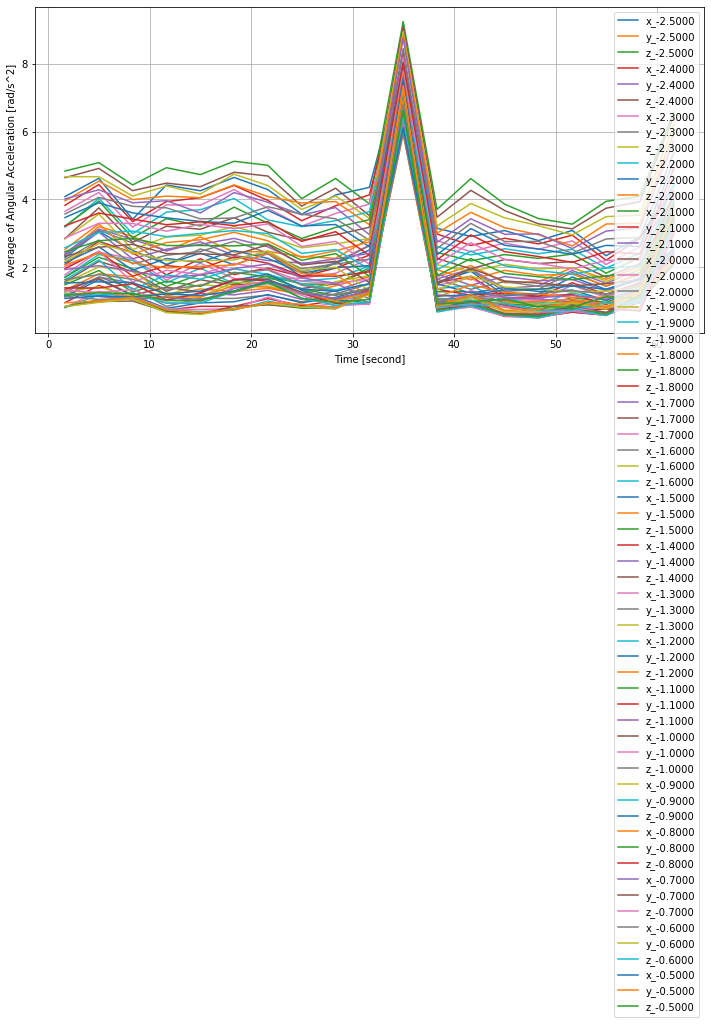

In [17]:
plotA4s(datas,legend,sampling_rate=30,length=100)

In [18]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:2]
    else:
        datas = np.append(datas,data[1:2],axis=0)

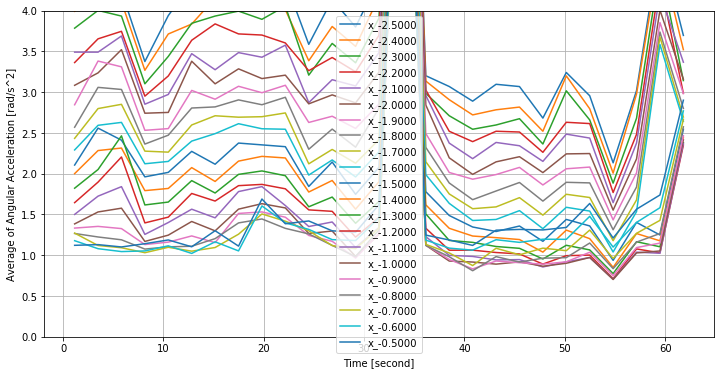

In [19]:
plotA4s(datas,legend,sampling_rate=30,length=70,ylim=[0,4])

In [20]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[2:3]
    else:
        datas = np.append(datas,data[2:3],axis=0)

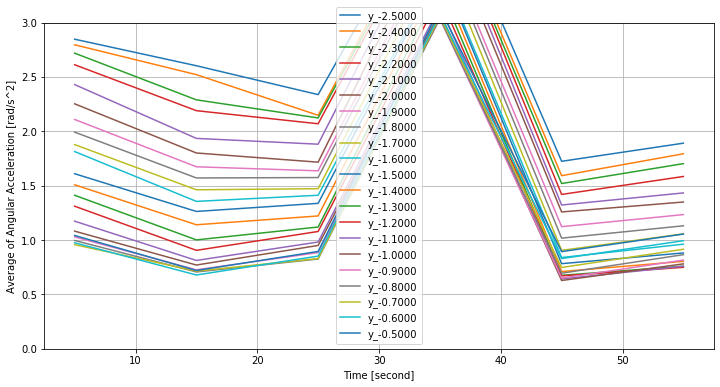

In [21]:
plotA4s(datas,legend,sampling_rate=30,length=300,ylim=[0,3])

iPhoneのデータセットの結果は分かった。ではVirtualGimbalの結果は？

In [22]:
def exec_vg_sd(offset): # Vaio10
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/syukugawara/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j records/2019-04-03_07.27.36.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [23]:
def exec_vg_sd(offset): # Mac + Pallarels
    cmd = './pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j records/2019-04-03_07.27.36.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [24]:
frame_offsets=np.linspace(-2.0,2.0,21)

for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for fo in frame_offsets:
    exec_vg_sd(fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [25]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:2] # X axis only
    else:
        datas = np.append(datas,data[1:2],axis=0) # X axis only


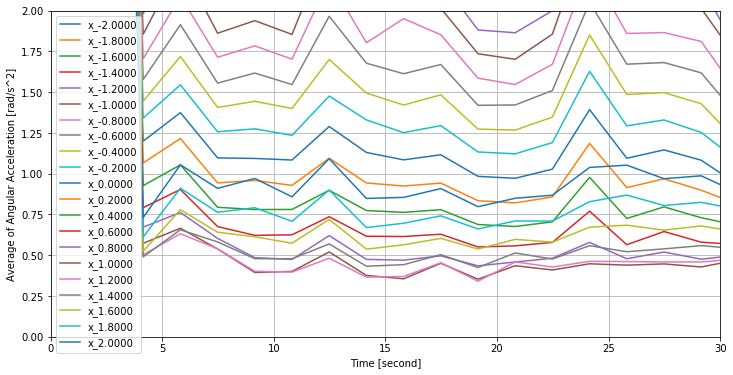

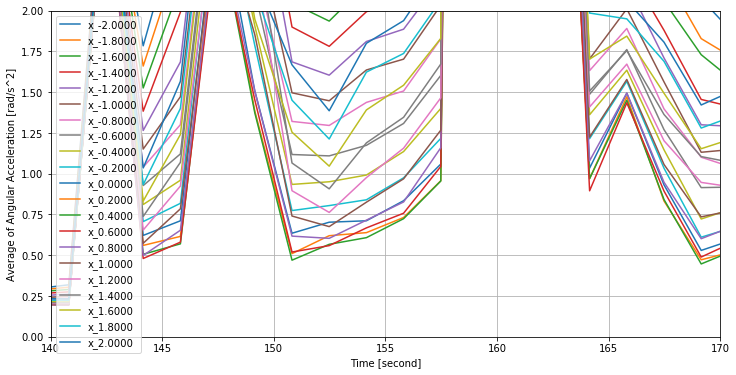

In [26]:
plotA4s(datas,legend,sampling_rate=30,length=50,xlim=[0,30],ylim=[0,2])
plotA4s(datas,legend,sampling_rate=30,length=50,xlim=[140,170],ylim=[0,2])

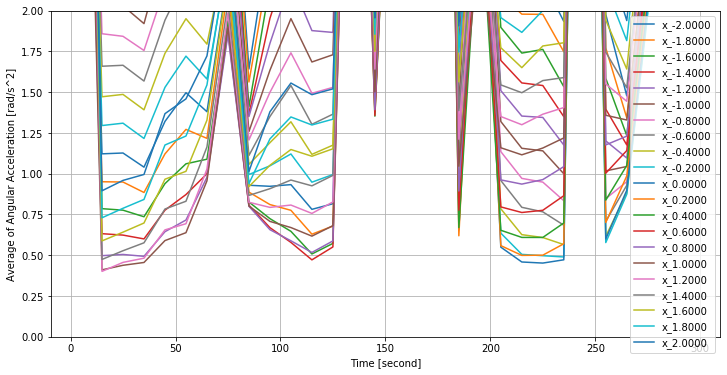

In [27]:
plotA4s(datas,legend,sampling_rate=30,length=300,ylim=[0,2])

In [28]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    

    # データを結合する
    if datas is None:
        datas = data[1:]
    else:
        datas = np.append(datas,data[1:],axis=0)

In [29]:
legend = []
original_datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    # data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    data = openCSV('../build/latest_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    

    # データを結合する
    if original_datas is None:
        original_datas = data[1:]
    else:
        original_datas = np.append(original_datas,data[1:],axis=0)


In [30]:
def plotRelativeA4s(angular_velocitys,original_angular_velocity,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    plt.figure(figsize=(10,6))

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
    


    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()

No handles with labels found to put in legend.


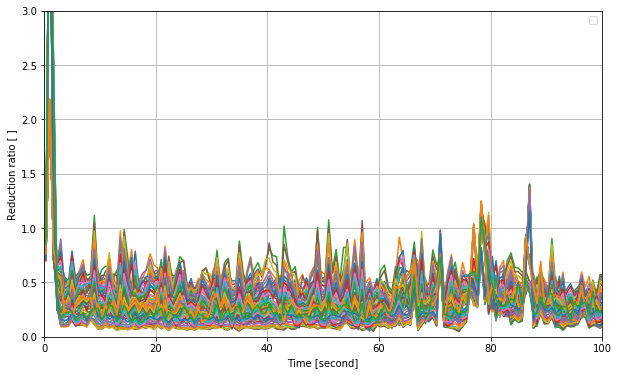

In [31]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,length=20,xlim=[0,100],ylim=[0,3])

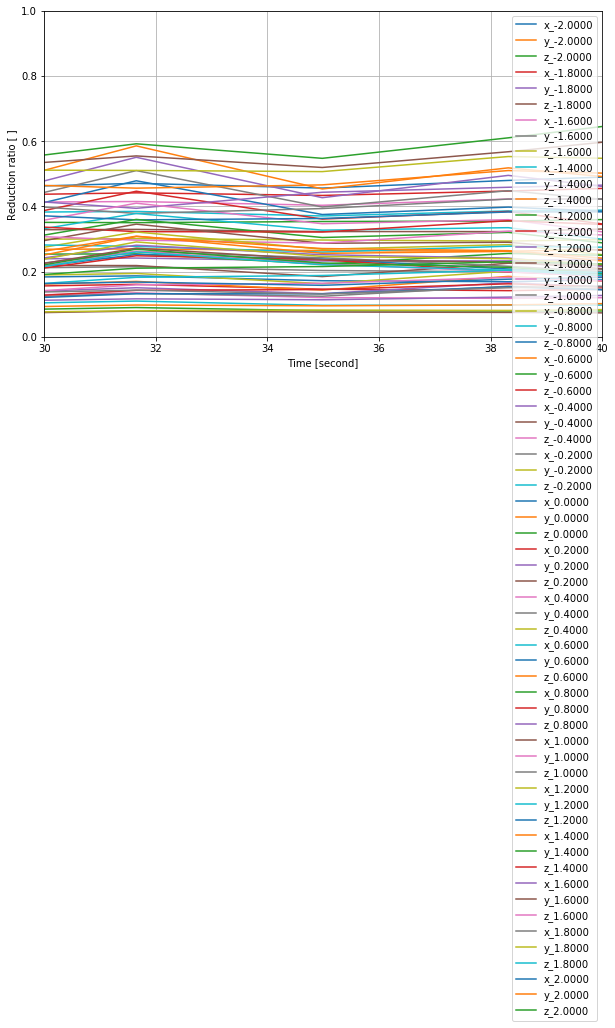

In [32]:
plotRelativeA4s(datas,original_datas, legends=legend, sampling_rate=30.,length=100,xlim=[30,40],ylim=[0,1])

No handles with labels found to put in legend.


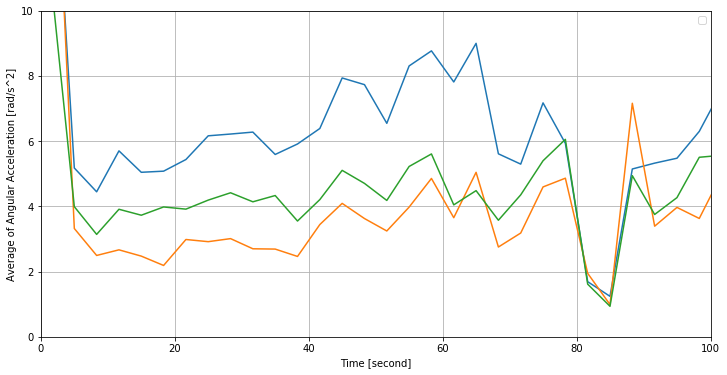

In [33]:
plotA4s(original_datas[0:3],length=100,ylim=[0,10],xlim=[0,100])

No handles with labels found to put in legend.


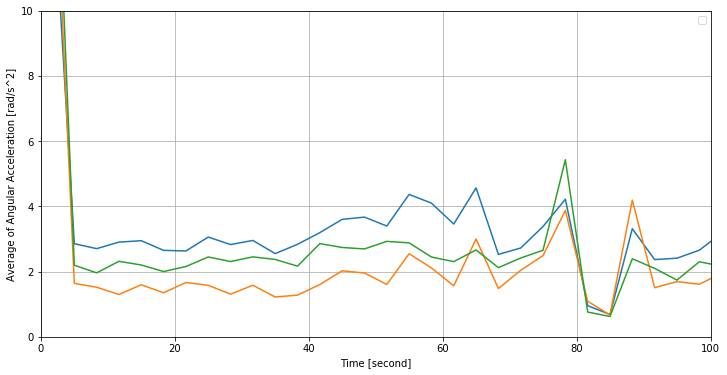

In [34]:
plotA4s(datas[0:3],ylim=[0,10],length=100,xlim=[0,100])

In [35]:
ds = []
for d in datas:
    # print(d.shape)
    aaa = getAverageOfAbsAngularAcceleration(d,30.)
    # print(aaa)
    ds.append(aaa)

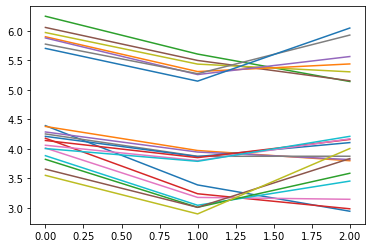

In [36]:
plt.plot(np.reshape(np.array(ds),(3,21)))

In [37]:
legend = []
xdatas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    

    # データを結合する
    if xdatas is None:
        xdatas = data[1:2]
    else:
        xdatas = np.append(xdatas,data[1:2],axis=0)

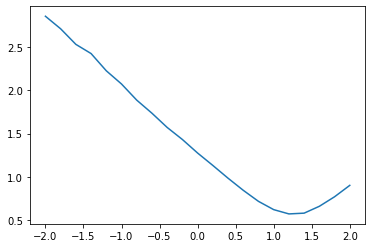

In [38]:
ds = []
for d in xdatas:
    # print(d.shape)
    aaa = getAverageOfAbsAngularAcceleration(d[100:200],30.)
    # print(aaa)
    ds.append(aaa)

plt.plot(frame_offsets,ds)

In [39]:
def plotAverageRelativeA4s(angular_velocitys,original_angular_velocity,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    ratio = []

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
            ratio.append(np.average(a4)/np.average(oa4))
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
            ratio.append(np.average(a4)/np.average(oa4))
        


    rsratio = np.reshape(np.array(ratio),(21,3))

    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,0])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,1])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.plot(frame_offset,rsratio[:,2])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')          
    plt.legend()
    plt.grid()
    plt.show()

    return rsratio

No handles with labels found to put in legend.


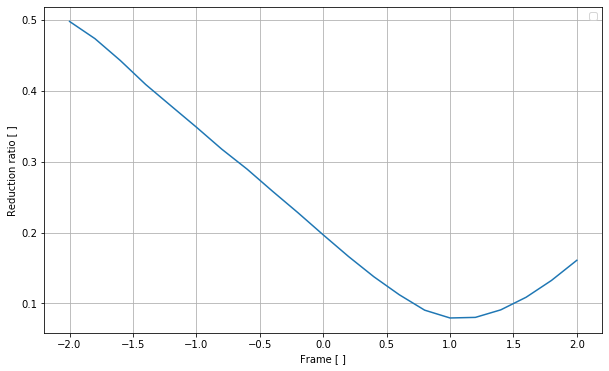

No handles with labels found to put in legend.


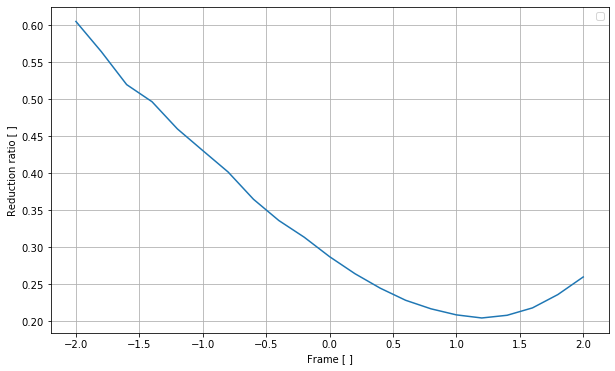

No handles with labels found to put in legend.


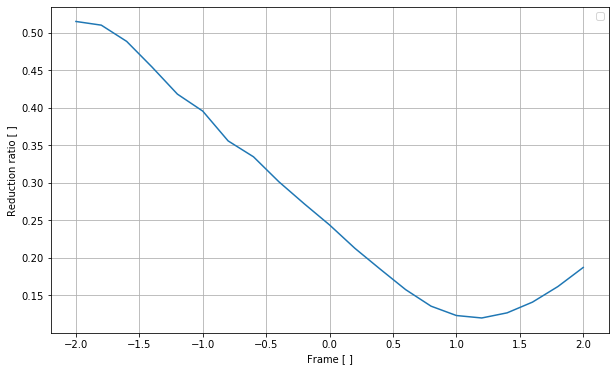

array([[0.49770726, 0.60529496, 0.51526003],
       [0.47349338, 0.56449256, 0.5103403 ],
       [0.44268815, 0.5198844 , 0.48869994],
       [0.40884768, 0.49674018, 0.45448086],
       [0.37867793, 0.45998444, 0.41839584],
       [0.34866797, 0.43071954, 0.39573118],
       [0.31766523, 0.40168805, 0.35600861],
       [0.28944111, 0.36482265, 0.33482014],
       [0.25836357, 0.33608297, 0.30157213],
       [0.22816007, 0.31352028, 0.2722136 ],
       [0.1968176 , 0.28720336, 0.2439574 ],
       [0.16621486, 0.26418171, 0.21275695],
       [0.13765195, 0.24453482, 0.18491864],
       [0.11234264, 0.22820507, 0.1576897 ],
       [0.09060654, 0.21665978, 0.13567735],
       [0.07958401, 0.20848393, 0.12318358],
       [0.08041015, 0.20429402, 0.11992122],
       [0.09102152, 0.20794798, 0.12676436],
       [0.10880623, 0.21793339, 0.14105753],
       [0.13251764, 0.2359439 , 0.16178377],
       [0.16094701, 0.25975896, 0.1872679 ]])

In [40]:
plotAverageRelativeA4s(datas[:,500:700],original_datas[:,500:700], frame_offset=frame_offsets, sampling_rate=30.,length=20)

No handles with labels found to put in legend.


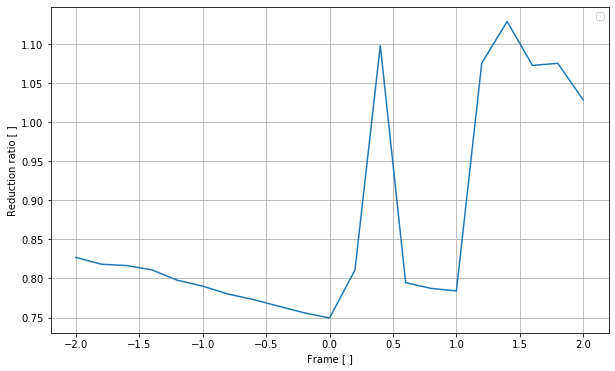

No handles with labels found to put in legend.


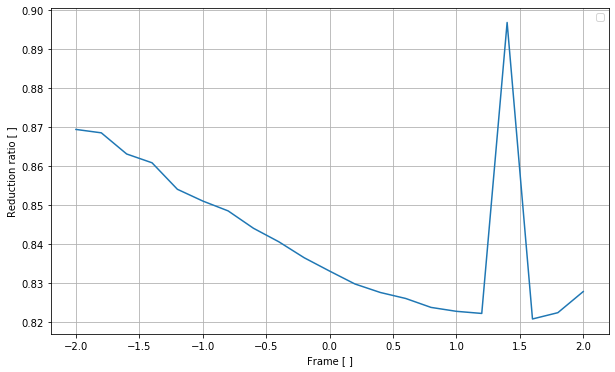

No handles with labels found to put in legend.


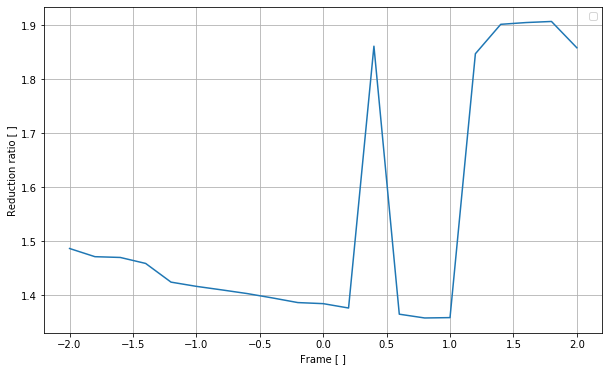

array([[0.82690828, 0.86940515, 1.48674732],
       [0.8182682 , 0.86853286, 1.47160367],
       [0.81655236, 0.8631036 , 1.47017037],
       [0.81096887, 0.8608464 , 1.45911387],
       [0.79776437, 0.8540464 , 1.42454678],
       [0.79017491, 0.85103423, 1.41671549],
       [0.77999908, 0.84850124, 1.41019247],
       [0.77298676, 0.84404088, 1.40341485],
       [0.76438552, 0.84057303, 1.3953226 ],
       [0.75599941, 0.83647545, 1.38672868],
       [0.74940665, 0.83306284, 1.38475304],
       [0.81077161, 0.82974659, 1.37667879],
       [1.09836094, 0.82756606, 1.86085986],
       [0.79464347, 0.82603036, 1.36525957],
       [0.78727088, 0.82373669, 1.35826031],
       [0.78408623, 0.8227312 , 1.3589342 ],
       [1.07576816, 0.82218817, 1.84687772],
       [1.12921066, 0.89685381, 1.90129432],
       [1.07294845, 0.82076782, 1.90456586],
       [1.07556687, 0.82238144, 1.90657654],
       [1.02870318, 0.8277975 , 1.85794818]])

In [41]:
plotAverageRelativeA4s(datas[:,0:200],original_datas[:,0:200], frame_offset=frame_offsets, sampling_rate=30.,length=20)

No handles with labels found to put in legend.


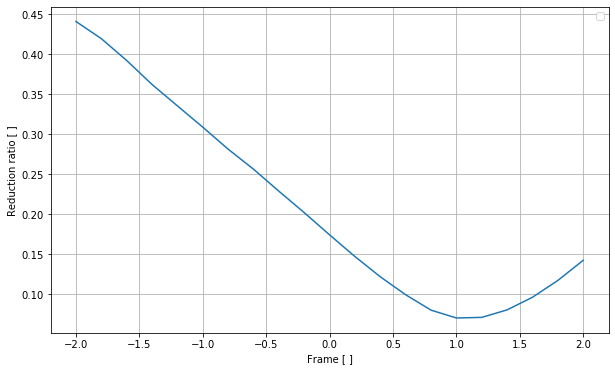

No handles with labels found to put in legend.


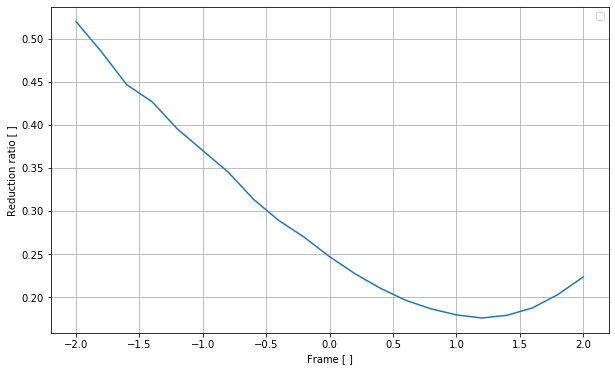

No handles with labels found to put in legend.


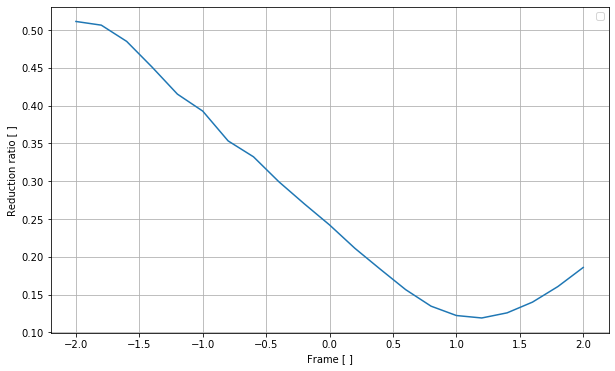

In [42]:
red_ratio = plotAverageRelativeA4s(datas[:,500:700],original_datas[:,30*33:40*33], frame_offset=frame_offsets, sampling_rate=30.,length=20)

In [43]:
# 最小値のframeを取得する
print(frame_offsets[np.argmin(red_ratio[:,0])]) # x軸
print(frame_offsets[np.argmin(red_ratio[:,1])]) # y軸
print(frame_offsets[np.argmin(red_ratio[:,2])]) # z軸

1.0
1.2000000000000002
1.2000000000000002


No handles with labels found to put in legend.


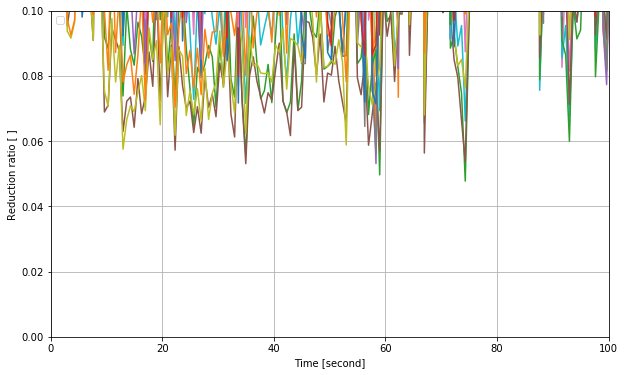

In [44]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,length=20,xlim=[0,100],ylim=[0,0.1])